In [1]:
from pathlib import Path
import numpy as np
import torch
import torch_geometric
import torch_scatter

from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.rcParams.update({'font.size':16})

In [3]:
path = Path("../data/synthetic")
with np.load(path/"answers.npz") as f:
    ocr = torch.Tensor(f["off_center"])
    prm = torch.Tensor(f["perimeter"])
cnn = torch.Tensor( np.load(path/"cnn.npy") )
syn = torch.Tensor( np.load(path/"synthetic.npy") )

In [4]:
print(cnn.shape)
print(syn.shape)

torch.Size([20000, 20, 20, 20, 3])
torch.Size([20000, 2, 100, 3])


In [5]:
cnn0 = cnn[0,:,:,:,0]
cnn0_side = cnn[0,:,:,:,2]

syn0 = syn[0,0,:3]
syn0_side = syn[0,1,:3]
print(cnn0.shape)
print(syn0.shape)

torch.Size([20, 20, 20])
torch.Size([3, 3])


In [6]:
print("Atom (special):\n", syn0)
print("Sidechain:\n", syn0_side)

Atom (special):
 tensor([[ 6.0931,  8.7850, 14.1665],
        [ 4.7508,  9.6950,  4.5027],
        [ 8.1999, 11.1518, 14.9324]])
Sidechain:
 tensor([[ 0.2962,  0.5191,  0.8017],
        [ 0.6347, -0.0303, -0.7722],
        [-0.2854,  0.5087, -0.8123]])


In [27]:
def plot_voxel(cnn, idx):
    """
    point: 20x20x20 Tensor
    """
    sidechains = cnn[idx,:,:,:,2]
    # atoms_all = torch.cat( (cnn[idx,:,:,:,0], cnn[idx,:,:,:,1]), 0 )
    special_atoms = cnn[idx,:,:,:,0]
    atoms = cnn[idx,:,:,:,1]
    
    # ensure zero (==0) or close to zero (<0.1) values don't get plotted
    # sidechains[(sidechains==0)] = np.nan
    # atoms[(atoms==0)] = np.nan
    # special_atoms[(special_atoms==0)] = np.nan
    sidechains[(sidechains < 0.1)] = np.nan
    atoms[(atoms<0.1)] = np.nan
    special_atoms[(special_atoms<0.1)] = np.nan

    X, Y = np.mgrid[:20, :20]

    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(1,2,1, projection='3d')
    for i in range(len(atoms)):
        # surf = ax.plot_surface(X,Y,atoms[i].numpy(), color='b')
        surf = ax.scatter(X,Y,atoms[i].numpy(), color='b', s=60, alpha=0.5)
        
    for i in range(len(special_atoms)):
        # surf = ax.plot_surface(X,Y,special_atoms[i].numpy(), color='red')
        surf = ax.scatter(X,Y,special_atoms[i].numpy(), color='red', s=60, alpha=0.5)
    ax.set_title("Atoms", fontsize=16)
    
    ax = fig.add_subplot(1,2,2, projection='3d')
    for i in range(len(sidechains)):
        # surf = ax.plot_surface(X,Y,sidechains[i].numpy(), color='orange')
        surf = ax.scatter(X,Y,sidechains[i].numpy(), color='orange', s=60, alpha=0.5)
    ax.set_title("Sidechains", fontsize=16)
    plt.suptitle(f"Point {idx}")
    plt.tight_layout()
    plt.show()

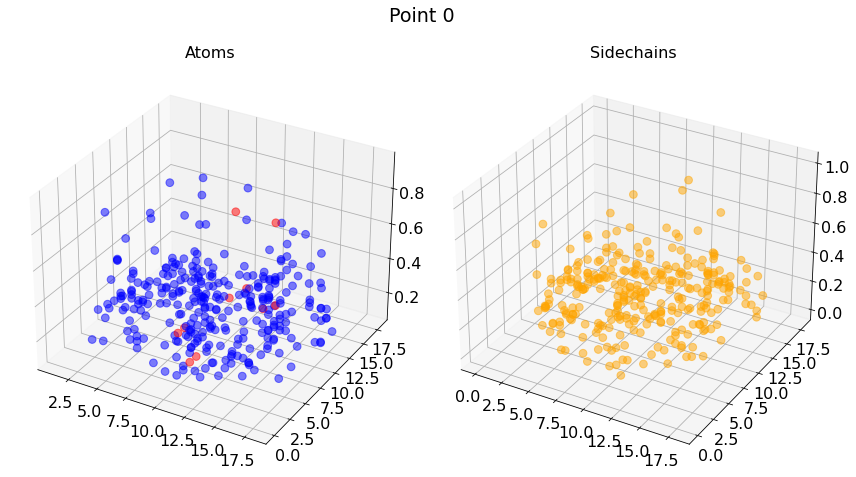

In [28]:
plot_voxel(cnn, 0)

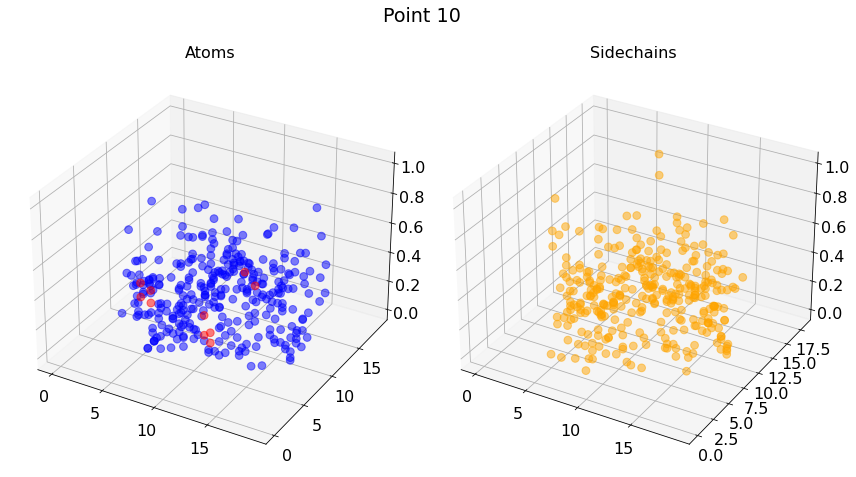

In [30]:
plot_voxel(cnn, 10)

# Dataset

In [32]:
class CNNDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="../data/synthetic", task=0, num_workers=8):
        # 0: off-center, 1: perimeter 2: combined
        super().__init__()
        self.data_dir = Path(data_dir)
        self.task = task
        self.num_workers = num_workers

    def setup(self, stage=None):
        X = torch.Tensor( np.load(self.data_dir/"cnn.npy") ).permute(0,4,1,2,3)
        X = X[:, ::2] # skip channel 1 - non-special atoms
        
        y = []
        with np.load(self.data_dir/"answers.npz") as f:
            y.append( torch.Tensor(f["off_center"]) )
            y.append( torch.Tensor(f["perimeter"]) )
        y.append( torch.stack((y[0],y[1]), dim=1) )

        dataset = TensorDataset(X, y[self.task])

        # Split
        full, test = random_split(dataset, [18000, 2000])

        if stage == 'fit' or stage is None:
            self.cnn_train, self.cnn_val = random_split(full, [16000, 2000])
            self.dims = tuple(self.cnn_train[0][0].shape)
        if stage == 'test' or stage is None:
            self.cnn_test = test
            self.dims = tuple(self.cnn_test[0][0].shape)
    
    def train_dataloader(self):
        return DataLoader(self.cnn_train, batch_size=32, num_workers=self.num_workers)
        
    def val_dataloader(self):
        return DataLoader(self.cnn_val, batch_size=32, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.cnn_test, batch_size=32, num_workers=self.num_workers)

# CNN model

In [33]:
class ShallowCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(N_FC, 32, (8,8,8))
        self.conv2 = nn.Conv3d(32, 32, (8,8,8)) 
        self.fc = nn.Linear(32, N_OUT)
    
    def forward(self, x):
        out = F.relu( self.conv1(x) )
        out = F.relu( self.conv2(out) )
        out = F.adaptive_max_pool3d(out, (1,1,1))
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(1))
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.mse_loss(y_hat, y.unsqueeze(1))
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(1))
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        return loss

In [38]:
N_FC = 2
N_OUT = 1

In [61]:
dm = CNNDataModule(task=0)
trainer = pl.Trainer()
model = ShallowCNN()

trainer.fit(model, dm)
trainer.test(datamodule=dm)
# To see the plots, on the terminal run: tensorboard --logdir ./lightning_logs


0:44<00:02, 12.02it/s, loss=0.254, v_num=0, val_loss=1.460, train_loss_step=0.172, train_loss_epoch=0.322]
Epoch 19:  89%|████████▉ | 500/563 [00:42<00:05, 11.68it/s, loss=0.333, v_num=0, val_loss=1.460, train_loss_step=0.430, train_loss_epoch=0.341]
Validating: 0it [00:00, ?it/s]
Epoch 20:  89%|████████▉ | 500/563 [00:43<00:05, 11.61it/s, loss=0.437, v_num=0, val_loss=1.020, train_loss_step=0.366, train_loss_epoch=0.314]
Validating: 0it [00:00, ?it/s]
Epoch 21:  89%|████████▉ | 500/563 [00:43<00:05, 11.52it/s, loss=0.427, v_num=0, val_loss=1.220, train_loss_step=0.464, train_loss_epoch=0.304]
Validating: 0it [00:00, ?it/s]
Epoch 22:  89%|████████▉ | 500/563 [00:42<00:05, 11.71it/s, loss=0.275, v_num=0, val_loss=1.060, train_loss_step=0.357, train_loss_epoch=0.310]
Validating: 0it [00:00, ?it/s]
Epoch 23:  89%|████████▉ | 500/563 [00:43<00:05, 11.48it/s, loss=0.168, v_num=0, val_loss=1.480, train_loss_step=0.157, train_loss_epoch=0.297] 
Validating: 0it [00:00, ?it/s]
Epoch 24:  89%|██

[{'test_loss': 0.40247848629951477}]

# Loading from checkpoint

In [41]:
model = ShallowCNN.load_from_checkpoint("./lightning_logs/version_0/checkpoints/epoch=8-step=4499.ckpt")
model.eval()

dm = CNNDataModule(task=0)
trainer = pl.Trainer()
trainer.test(model, datamodule=dm)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Testing: 100%|██████████| 63/63 [00:03<00:00, 15.97it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4366453289985657}
--------------------------------------------------------------------------------


[{'test_loss': 0.4366453289985657}]